In [1]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt

from dotenv import dotenv_values
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, Q
import rasterio
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import numpy as np
import matplotlib.colors as mcol
from tqdm import tqdm
import pandas as pd

# Get DSWx Table

The table represents Planet image and HLS ID that will be used for comparison. There is not a 1-1 relationship between these datasets as multiple Planet Images can span several HLS tiles or an HLS tiles can be validated using multiple Planet Images.

In [2]:
df_dswx= gpd.read_file('s3://opera-calval-database-dswx/image.geojson')
df_dswx.head()

,cloud_cover,collocated_dswx,datetime,image_name,instrument,provider,resolution,s3_bucket,s3_key_image,site_coverage,site_name,timeDelta_days,geometry
0,0.0,HLS.S30.T10VEK.2021268T192141.v2.0,2021-09-25 19:17:08,20210925_191708_94_2408,PSB.SD,planetscope,3.0,opera-calval-database-dswx-private,data/3_42/20210925_191708_94_2408/20210925_191...,84.975663,3_42,0.007904,"POLYGON ((-122.94132 57.97664, -123.03517 57.7..."
1,0.0,HLS.L30.T18UXG.2021300T154817.v2.0,2021-10-27 15:14:45,20211027_151445_21_2231,PSB.SD,planetscope,3.0,opera-calval-database-dswx-private,data/4_21/20211027_151445_21_2231/20211027_151...,52.216780,4_21,0.023288,"POLYGON ((-71.93982 55.28796, -72.02213 55.104..."
2,0.0,HLS.S30.T18FYH.2021302T141741.v2.0,2021-10-30 14:26:13,20211030_142613_41_227b,PSB.SD,planetscope,3.0,opera-calval-database-dswx-private,data/2_8/20211030_142613_41_227b/20211030_1426...,74.756870,2_8,0.992265,"POLYGON ((-71.22036 -51.94097, -71.30174 -52.1..."
3,0.0,HLS.S30.T36LWH.2021268T073641.v2.0,2021-09-26 07:24:14,20210926_072414_71_2233,PSB.SD,planetscope,3.0,opera-calval-database-dswx-private,data/4_3/20210926_072414_71_2233/20210926_0724...,97.600689,4_3,0.972010,"POLYGON ((33.42779 -16.15910, 33.38993 -16.342..."
4,0.0,HLS.S30.T15VUK.2021244T175911.v2.0,2021-09-01 17:52:05,20210901_175205_71_2426,PSB.SD,planetscope,3.0,opera-calval-database-dswx-private,data/4_34/20210901_175205_71_2426/20210901_175...,96.416886,4_34,0.009994,"POLYGON ((-96.94381 62.88876, -97.07609 62.707..."


/var/folders/s6/fbsc26cd0ddffbp3_knts_9c0wcxj1/T/ipykernel_93438/497585854.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_dswx.buffer(1).plot(ax=ax)


<AxesSubplot:>

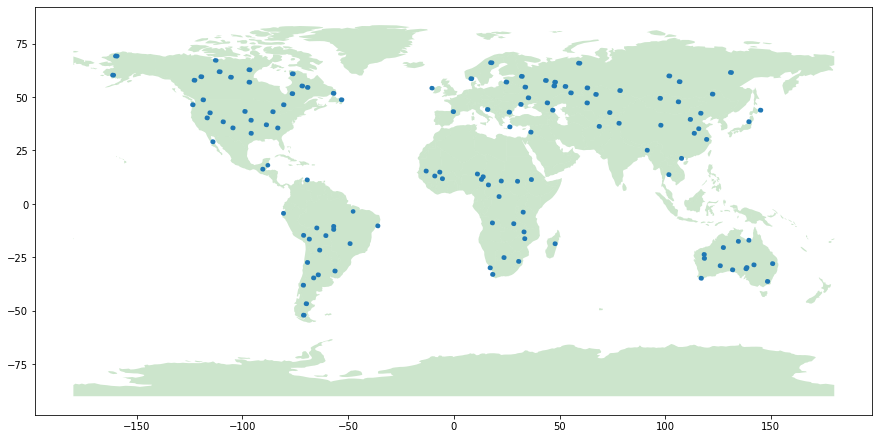

In [3]:
fig, ax = plt.subplots(figsize=(15, 10))
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

df_world.plot(ax=ax, fc='green', alpha=.2)
df_dswx.buffer(1).plot(ax=ax)

# Get Validation Dataset

In [7]:
df_class.to_dict('record')[0]

/var/folders/s6/fbsc26cd0ddffbp3_knts_9c0wcxj1/T/ipykernel_93438/1809161569.py:1: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  df_class.to_dict('record')[0]


{'feature_list': 'pixels (rgb) ,mean_superpixel (rgb for 3 segs),std_superpixels for rgb image (rgb for 3 segs)',
 'feature_importances': '0.175982,0.041749,0.013511,0.163051,0.061744,0.021546,0.155482,0.067378,0.037392,0.113966,0.096054,0.014273,0.001335,0.001349,0.000995,0.009478,0.002857,0.002213,0.009766,0.006372,0.003507',
 'accuracy': {'not_water': {'not_water': 163010, 'water': 210},
  'water': {'not_water': 268, 'water': 162887}},
 's3_bucket': 'opera-calval-dswx-jupyter',
 's3_prefix': 'classification_outputs_peckel/20210901_175205_71_2426',
 's3_keys': '20210901_175205_71_2426.ipynb,chip_cropped_20210901_175205_71_2426.tif,classification_20210901_175205_71_2426.tif,classification_HAND_UPDATES_20210901_175205_71_2426.tif,occurrence_20210901_175205_71_2426.tif,superpixel_means_scale-0_20210901_175205_71_2426.tif,training_data_reprojected_20210901_175205_71_2426.tif',
 'chip_id': 115,
 'strata': 4,
 'planet_id': '20210901_175205_71_2426',
 'geometry': <shapely.geometry.polygon.P

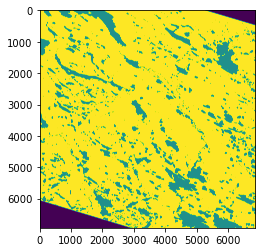

In [14]:
with rasterio.open('s3://opera-calval-dswx-jupyter/classification_outputs_peckel/20210901_175205_71_2426/classification_20210901_175205_71_2426.tif') as ds:
    X = ds.read(1)
    
plt.imshow(X)

In [4]:
JUPYTER_BUCKET_NAME = 'opera-calval-dswx-jupyter'
JUPYTER_TABLE_NAME = f'dswx_classification_rf_peckel.geojson'
df_class = gpd.read_file(f's3://{JUPYTER_BUCKET_NAME}/{JUPYTER_TABLE_NAME}', driver='GeoJSON')
df_class.head()

,feature_list,feature_importances,accuracy,s3_bucket,s3_prefix,s3_keys,chip_id,strata,planet_id,geometry
0,"pixels (rgb) ,mean_superpixel (rgb for 3 segs)...","0.175982,0.041749,0.013511,0.163051,0.061744,0...","{'not_water': {'not_water': 163010, 'water': 2...",opera-calval-dswx-jupyter,classification_outputs_peckel/20210901_175205_...,"20210901_175205_71_2426.ipynb,chip_cropped_202...",115,4,20210901_175205_71_2426,"POLYGON ((612168.818 6967451.512, 623464.758 6..."
1,"pixels (rgb) ,mean_superpixel (rgb for 3 segs)...","0.052740,0.021781,0.064353,0.069581,0.022370,0...","{'not_water': {'not_water': 27144, 'water': 2}...",opera-calval-dswx-jupyter,classification_outputs_peckel/20210906_183639_...,"20210906_183639_52_240c.ipynb,chip_cropped_202...",16,2,20210906_183639_52_240c,"POLYGON ((518606.228 4463298.082, 537382.421 4..."
2,"pixels (rgb) ,mean_superpixel (rgb for 3 segs)...","0.097939,0.021023,0.016045,0.105957,0.033215,0...","{'not_water': {'not_water': 52374, 'water': 17...",opera-calval-dswx-jupyter,classification_outputs_peckel/20210914_051809_...,"20210914_051809_10_2455.ipynb,chip_cropped_202...",109,1,20210914_051809_10_2455,"POLYGON ((484725.808 4023892.372, 490804.086 4..."
3,"pixels (rgb) ,mean_superpixel (rgb for 3 segs)...","0.136184,0.001254,0.000614,0.134204,0.006352,0...","{'not_water': {'not_water': 24186, 'water': 5}...",opera-calval-dswx-jupyter,classification_outputs_peckel/20210924_082025_...,"20210924_082025_48_2424.ipynb,chip_cropped_202...",70,4,20210924_082025_48_2424,"POLYGON ((657224.012 8984934.146, 657143.906 8..."
4,"pixels (rgb) ,mean_superpixel (rgb for 3 segs)...","0.066320,0.023198,0.045239,0.076251,0.031792,0...","{'not_water': {'not_water': 76170, 'water': 2}...",opera-calval-dswx-jupyter,classification_outputs_peckel/20210925_191708_...,".DS_Store,20210925_191708_94_2408.ipynb,chip_c...",77,3,20210925_191708_94_2408,"POLYGON ((497825.315 6424257.440, 499704.124 6..."


In [9]:
r = df_class.to_dict('records')[0]
r

{'feature_list': 'pixels (rgb) ,mean_superpixel (rgb for 3 segs),std_superpixels for rgb image (rgb for 3 segs)',
 'feature_importances': '0.175982,0.041749,0.013511,0.163051,0.061744,0.021546,0.155482,0.067378,0.037392,0.113966,0.096054,0.014273,0.001335,0.001349,0.000995,0.009478,0.002857,0.002213,0.009766,0.006372,0.003507',
 'accuracy': {'not_water': {'not_water': 163010, 'water': 210},
  'water': {'not_water': 268, 'water': 162887}},
 's3_bucket': 'opera-calval-dswx-jupyter',
 's3_prefix': 'classification_outputs_peckel/20210901_175205_71_2426',
 's3_keys': '20210901_175205_71_2426.ipynb,chip_cropped_20210901_175205_71_2426.tif,classification_20210901_175205_71_2426.tif,classification_HAND_UPDATES_20210901_175205_71_2426.tif,occurrence_20210901_175205_71_2426.tif,superpixel_means_scale-0_20210901_175205_71_2426.tif,training_data_reprojected_20210901_175205_71_2426.tif',
 'chip_id': 115,
 'strata': 4,
 'planet_id': '20210901_175205_71_2426',
 'geometry': <shapely.geometry.polygon.P

In [10]:
r["s3_bucket"], r["s3_prefix"]

('opera-calval-dswx-jupyter',
 'classification_outputs_peckel/20210901_175205_71_2426')

In [17]:
with rasterio.open(f's3://{r["s3_bucket"]}/{r["s3_prefix"]}/classification_20210901_175205_71_2426.tif') as ds:
    X_val = ds.read(1)
    p_val = ds.profile

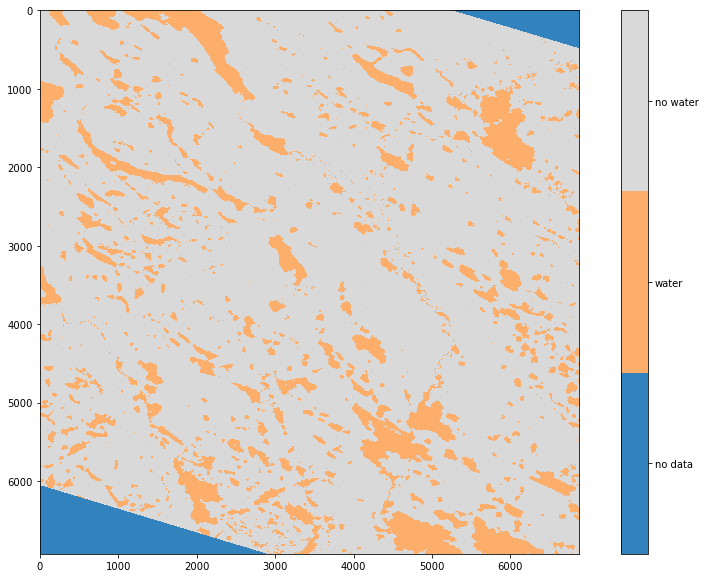

In [18]:
plt.figure(figsize=(15, 10))

classes = np.unique(X_val)
N = len(classes)

# Source: https://stackoverflow.com/questions/9707676/defining-a-discrete-colormap-for-imshow-in-matplotlib
cmap = cm.get_cmap("tab20c",lut=(N + 1))
norm = mcol.BoundaryNorm(np.arange(N+1), cmap.N)

im = plt.imshow(X_val, cmap=cmap, interpolation='none', norm=norm)
cbar = plt.colorbar(im,ticks=classes + .5,orientation="vertical")
cbar.set_ticklabels(["no data", "water", "no water"])

# Get Provisional Product

In [9]:
config = dotenv_values()
ES_USERNAME = config['ES_USERNAME']
ES_PASSWORD = config['ES_PASSWORD']

In [10]:
GRQ_URL = 'https://100.104.62.10/grq_es/'
grq_client = Elasticsearch(GRQ_URL, 
                           http_auth=(ES_USERNAME, ES_PASSWORD), 
                           verify_certs=False, 
                           read_timeout=50000, 
                           terminate_after=2500,
                          )
grq_client.ping()


/Users/cmarshak/opt/anaconda3/envs/dswx_val/lib/python3.10/site-packages/elasticsearch/connection/http_urllib3.py:209: UserWarning: Connecting to https://100.104.62.10:443 using SSL with verify_certs=False is insecure.
  warnings.warn(
/Users/cmarshak/opt/anaconda3/envs/dswx_val/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '100.104.62.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/cmarshak/opt/anaconda3/envs/dswx_val/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '100.104.62.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


True

In [11]:
search = Search(using=grq_client, 
                # wildcard is where the version is
                index='grq_*_l3_dswx_hls')

def _get_urls(data: dict) -> list:
    base_url = data['browse_urls'][0]
    base_url = base_url.replace('s3-website-us-west-2', 's3.us-west-2').replace('browse', 'products')
    all_file_names = [file_data['FileName'] for file_data in data['metadata']['Files']]
    
    urls = [f'{base_url}/{file_name}' for file_name in all_file_names]
    return urls

def get_DSWX_doc(hls_id: str) -> dict:
    tokens = HLS_ID.split('.')
    token_1 = tokens[2]
    token_2 = tokens[3]
    
    q_qs = Q('query_string', 
             query=f'\"{token_1}\" \"{token_2}\"', 
             default_field="id")
    
    query = search.query(q_qs)
    resp = query.execute()
    n = len(resp.hits)
    
    if n > 1:
        raise ValueError('Multiple DSWx Products for current query')
    
    if n == 0:
        raise ValueError('No DSWx products match HLS ID')
    data = resp.hits[0].to_dict()
    return data

def get_DSWx_urls(hls_id: str) -> list:
    doc = get_DSWX_doc(hls_id)
    return _get_urls(doc)

In [12]:
df_dswx.columns

Index(['cloud_cover', 'collocated_dswx', 'datetime', 'image_name',
       'instrument', 'provider', 'resolution', 's3_bucket', 's3_key_image',
       'site_coverage', 'site_name', 'timeDelta_days', 'geometry'],
      dtype='object')

In [13]:
20210925_191708_94_2408

20210925191708942408

In [14]:
HLS_ID = df_dswx[df_dswx.image_name == '20210925_191708_94_2408'].collocated_dswx[0]
HLS_ID

'HLS.S30.T10VEK.2021268T192141.v2.0'

In [15]:
urls = get_DSWx_urls(HLS_ID)
urls[0]

/Users/cmarshak/opt/anaconda3/envs/dswx_val/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '100.104.62.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


'http://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_S2A_30_T10VEK_20210925T192141Z_20220721T004819Z_v0.1_001/OPERA_L3_DSWx_HLS_S2A_30_T10VEK_20210925T192141Z_20220721T004819Z_v0.1_001_B01_WTR.tiff'

In [16]:
with rasterio.open(urls[0]) as ds:
    X_opera_original = ds.read(1)
    p_opera = ds.profile
    
   
# This looks approximately right
X_opera = (~(X_opera_original == 1)).astype(np.uint8)
X_opera += 1
X_opera[X_opera_original == 9] = 0

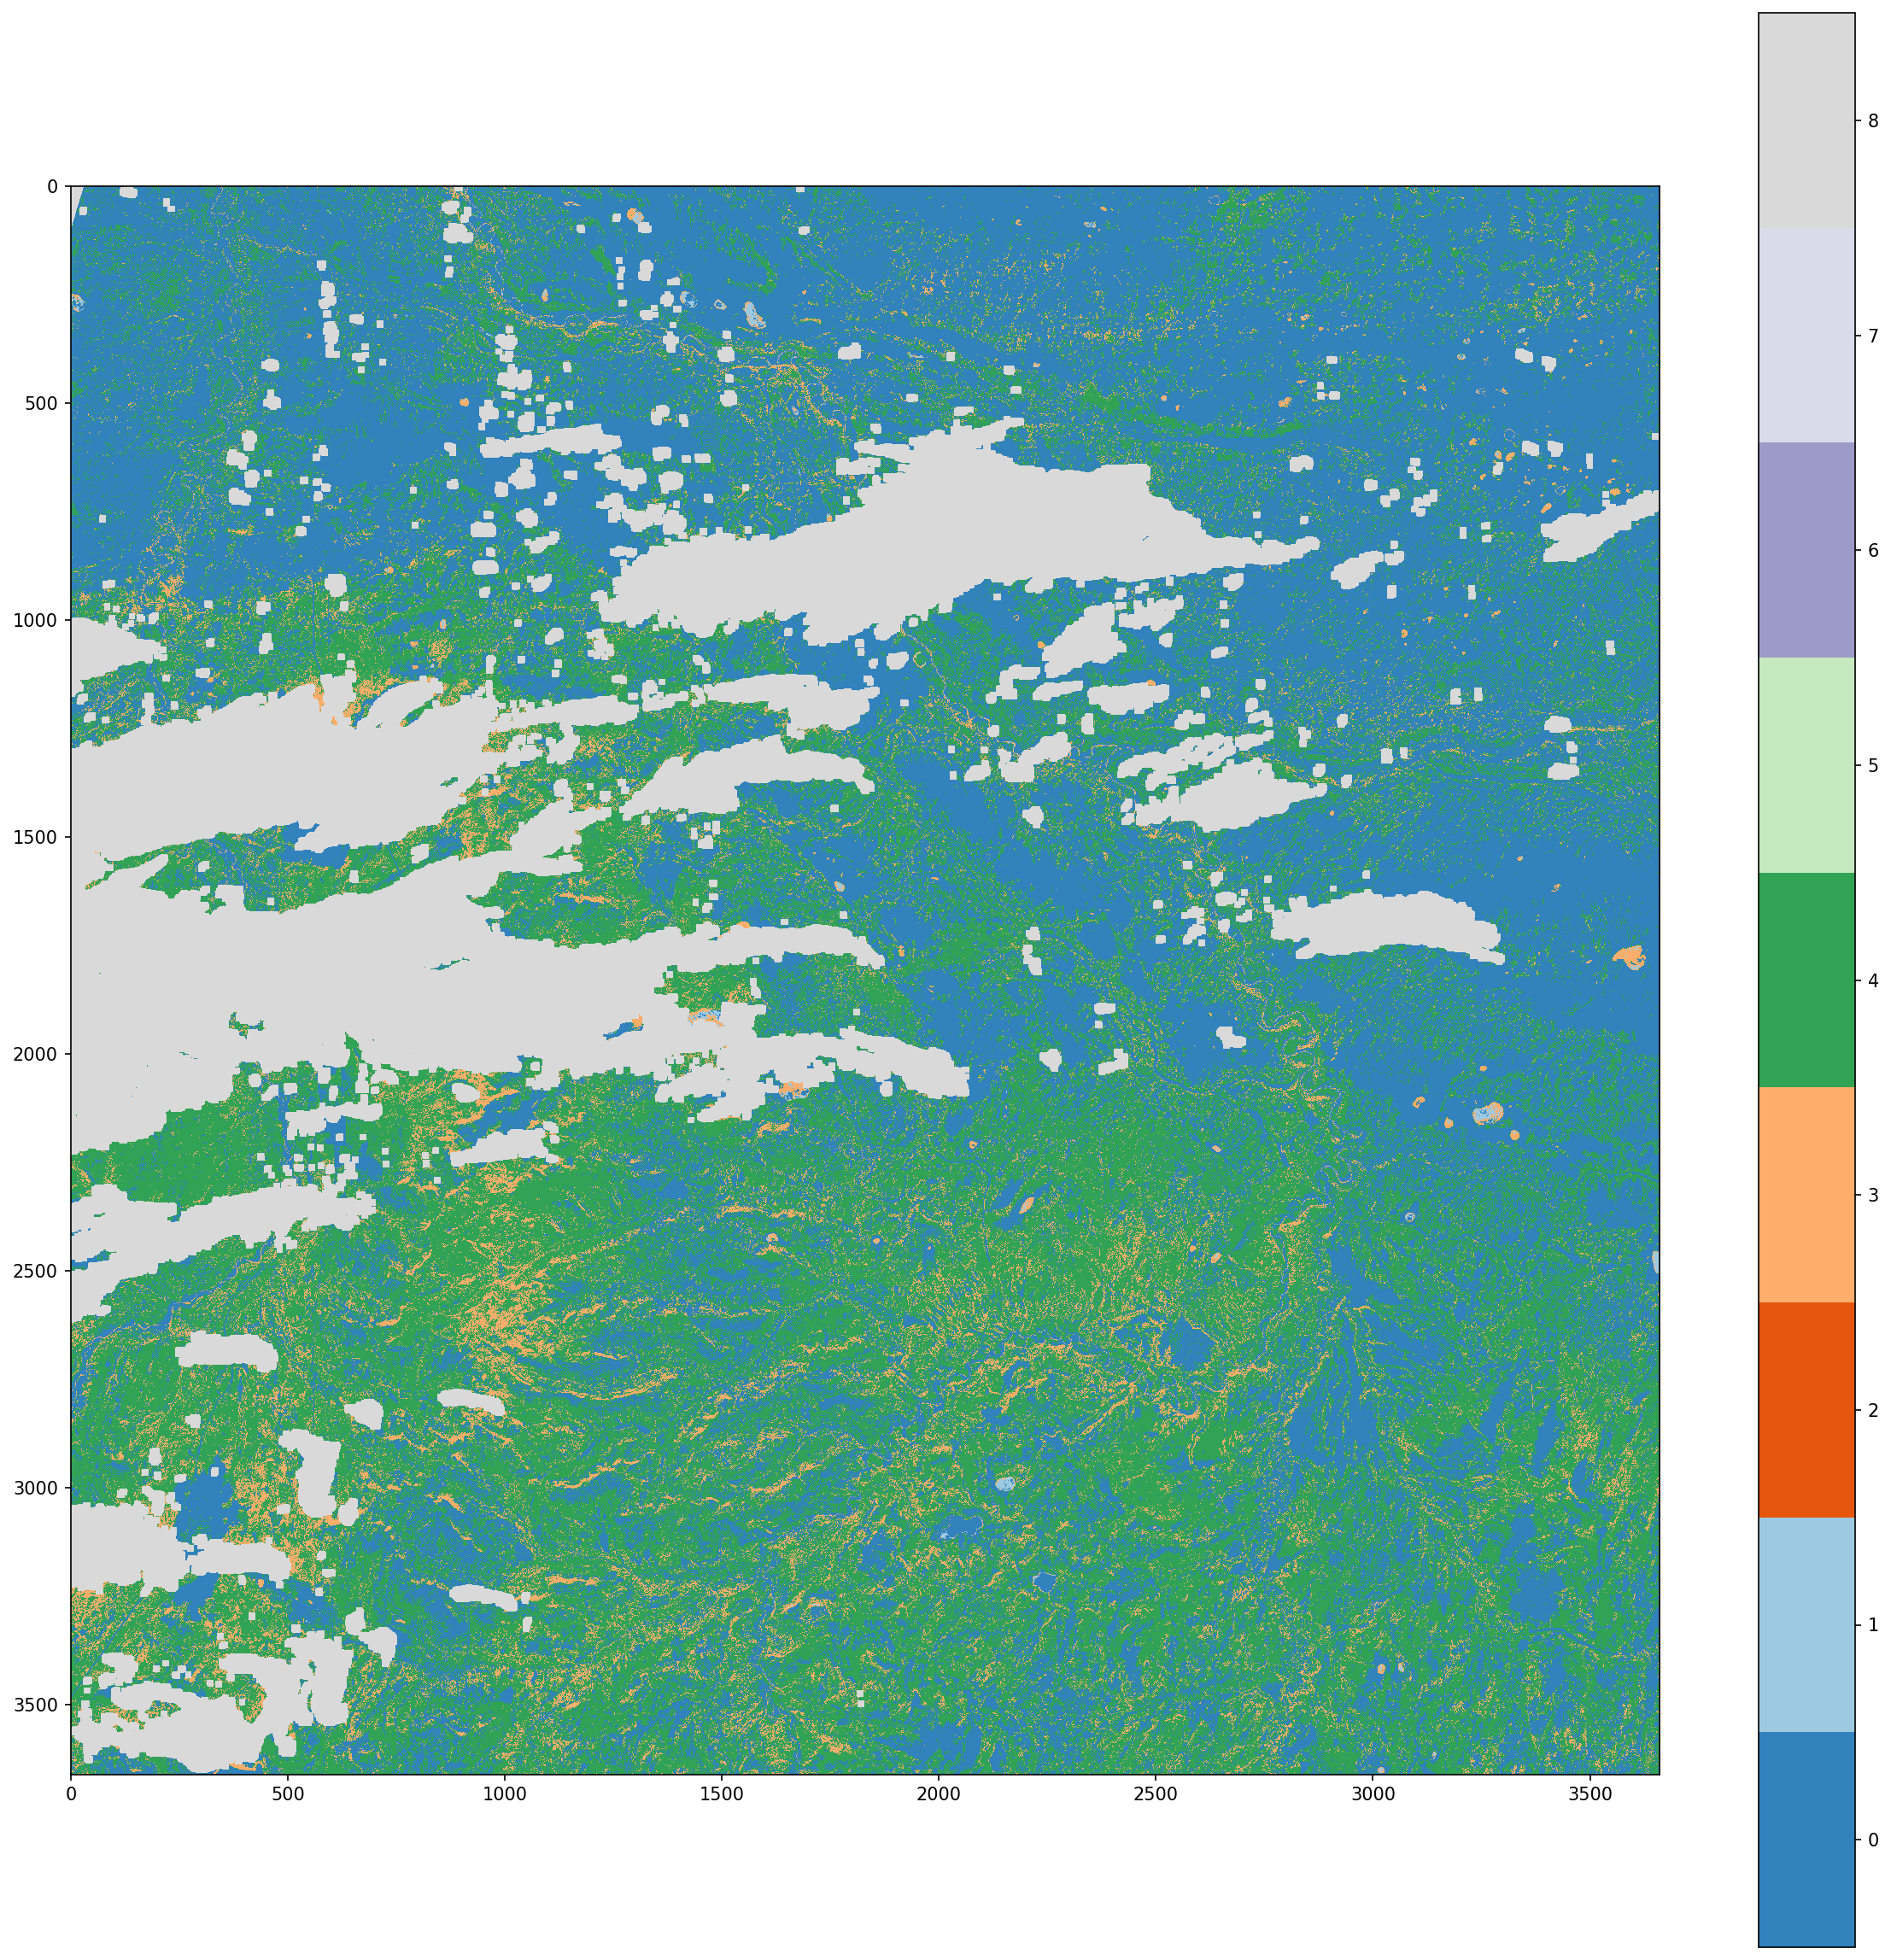

In [17]:
import matplotlib.cm as cm
import numpy as np
import matplotlib.colors as mcol

plt.figure(figsize=(20, 20), dpi=150)

classes = np.unique(X_opera_original)
classes = np.array([c for c in classes if c != 255])
classes = np.arange(min(classes), max(classes) + 1)
N = max(classes)

# Source: https://stackoverflow.com/questions/9707676/defining-a-discrete-colormap-for-imshow-in-matplotlib
cmap = cm.get_cmap("tab20c", lut=(N + 1))
norm = mcol.BoundaryNorm(np.arange(N + 1), cmap.N)

im = plt.imshow(X_opera_original, cmap=cmap, interpolation='none', norm=norm)
cbar = plt.colorbar(im,ticks=classes + .5, orientation="vertical")
cbar.set_ticklabels(classes)

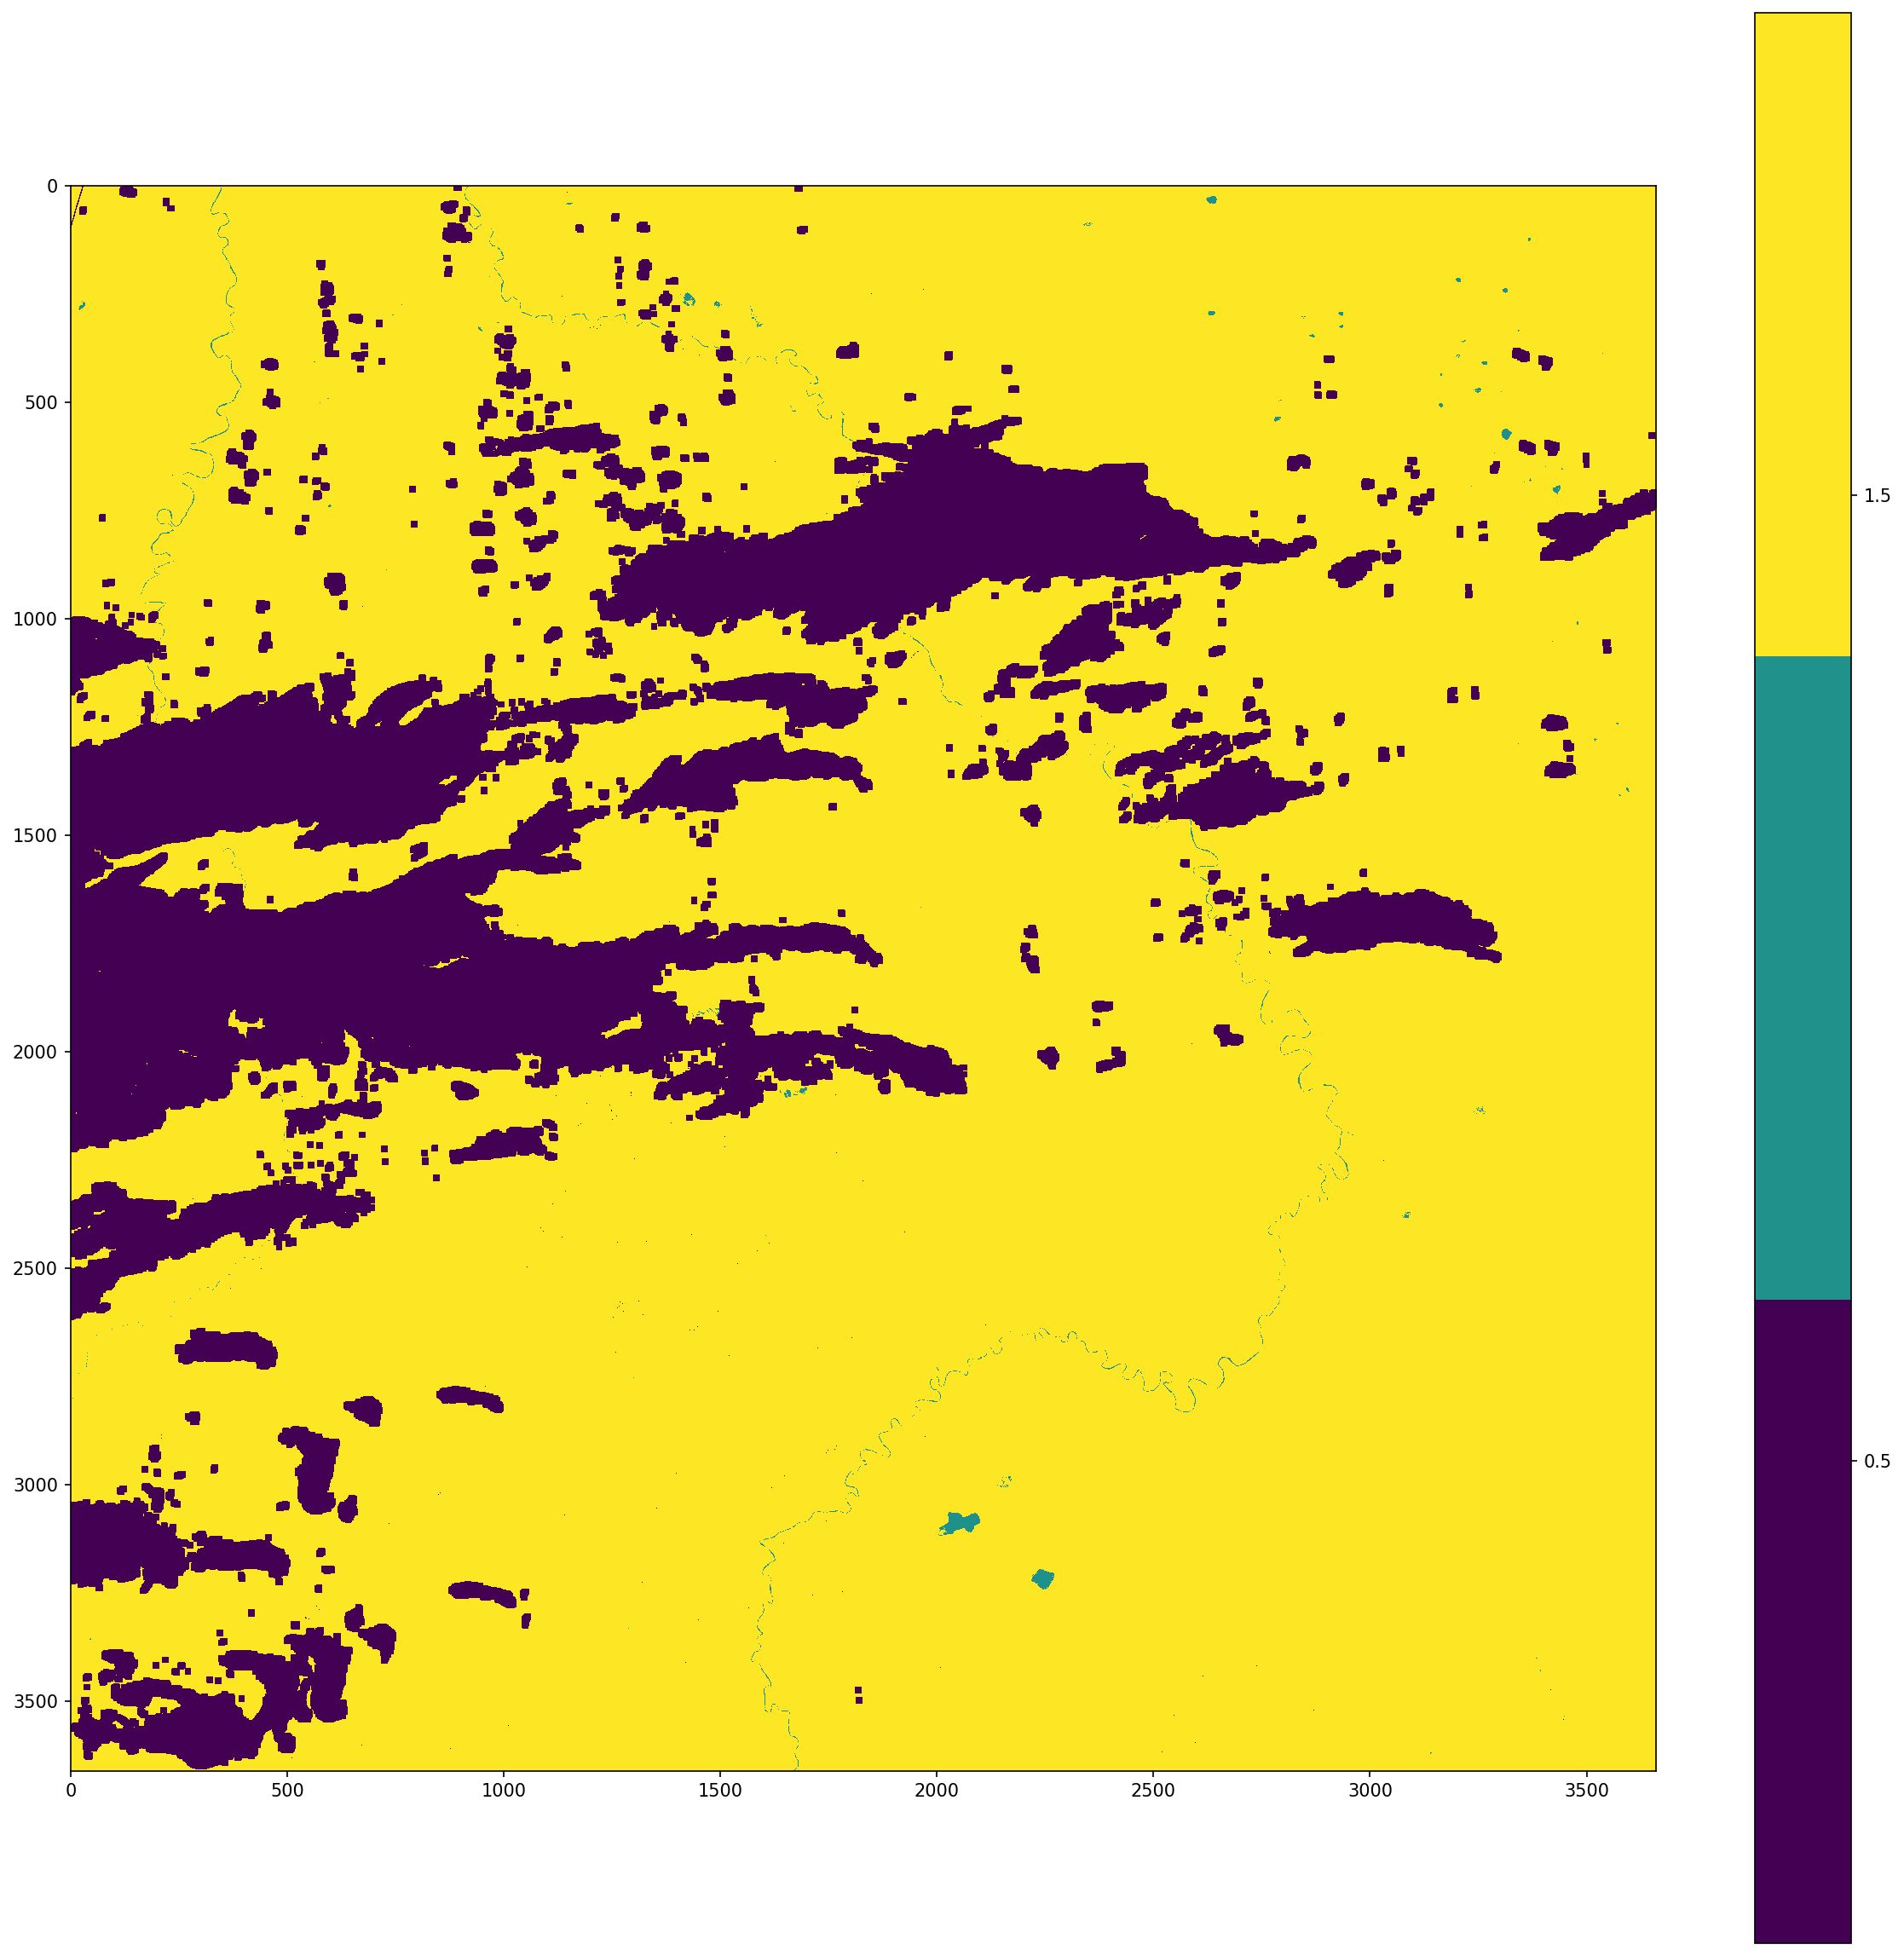

In [18]:
import matplotlib.cm as cm
import numpy as np
import matplotlib.colors as mcol

plt.figure(figsize=(20, 20), dpi=150)

classes = np.unique(X_opera)
classes = np.array([c for c in classes if c != 255])
classes = np.arange(min(classes), max(classes) + 1)
N = max(classes)

# Source: https://stackoverflow.com/questions/9707676/defining-a-discrete-colormap-for-imshow-in-matplotlib
cmap = cm.get_cmap("viridis", lut=(N + 1))
norm = mcol.BoundaryNorm(np.arange(N + 1), cmap.N)

im = plt.imshow(X_opera, cmap=cmap, interpolation='none', vmin=0, vmax=2)
cbar = plt.colorbar(im,ticks=classes + .5, orientation="vertical")


# Comparison

Very, very rough

In [19]:
from dem_stitcher.rio_tools import reproject_arr_to_match_profile

In [20]:
def resample_classification(arr_class: np.ndarray, 
                            prof_class: dict, 
                            ref_profile: dict,
                            threshold: float = .9,
                            classes: list = None,
                            nodata: int = None
                            ) -> np.ndarray:
    
    if prof_class['dtype'] not in ['uint8', 'int32', 'int64']:
        raise ValueError('Data must be integer valued')
    
    nodata = prof_class['nodata']
    classes = classes or np.unique(arr_class)
    classes = [c for c in classes if c != nodata]
    
    N_classes = len(classes)
    if (threshold < 1. / N_classes):
        raise ValueError('Threshold must be greater than 1. / {N_classes} (i.e. 1 / # of classes)')
    
    X_class_r = np.ones((ref_profile['height'], ref_profile['width'])) * nodata
    
    for c in tqdm(classes):
        if c == nodata:
            continue
        
        X_c1 = (arr_class == c).astype(np.uint8)
        X_c1, _ = reproject_arr_to_match_profile(X_c1, prof_class, ref_profile, resampling='bilinear')
        X_c1 = X_c1[0, ...]
        X_class_r[X_c1 > threshold] = c
    
    return X_class_r

In [21]:
p_opera

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 3660, 'height': 3660, 'count': 1, 'crs': CRS.from_wkt('PROJCS["UTM Zone 10, Northern Hemisphere",GEOGCS["Unknown datum based upon the WGS 84 ellipsoid",DATUM["Not_specified_based_on_WGS_84_spheroid",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 499980.0,
       0.0, -30.0, 6500040.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [22]:
X_val_r = resample_classification(X_val, p_val, p_opera)

100%|███████████████████████████████████████| 2/2 [00:01<00:00,  1.28it/s]


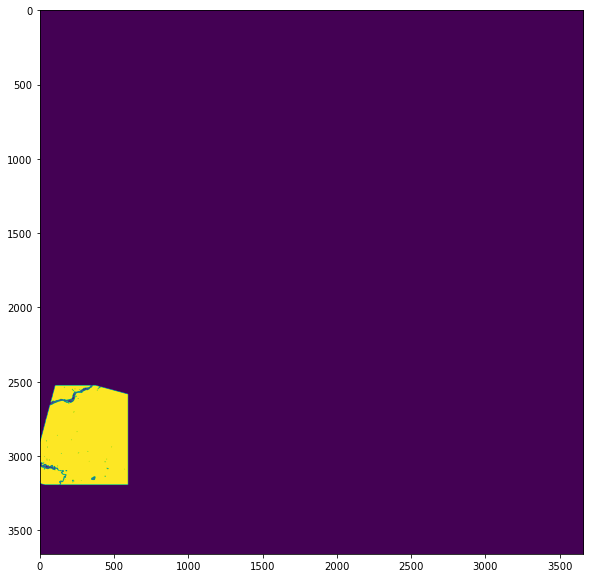

In [35]:
plt.figure(figsize=(10, 10))
plt.imshow(X_val_r)

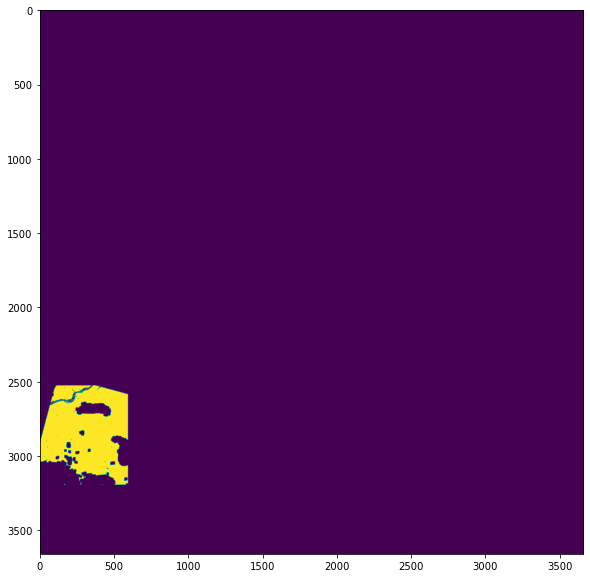

In [36]:
plt.figure(figsize=(10, 10))
Y = X_val_r.copy()
Y[X_opera_original == 9] = 0
plt.imshow(Y)

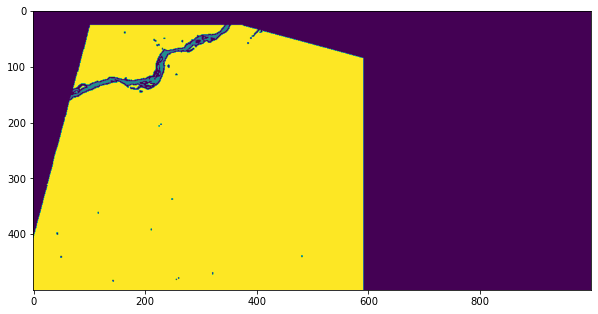

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(X_val_r[2500:3000, :1000])

# Compare

We will streamline this with in the future with consistent class labels

In [25]:
class_dict = {1: 'water', 
              2: 'not_water'}

In [26]:
mask = (X_val_r == 0) | (X_opera == 0)

y_opera = X_opera[~mask]
y_val = X_val_r[~mask]

In [27]:
class_dict = {1: 'water', 
              2: 'not_water'}

In [28]:
y_opera_str = pd.Series([class_dict[class_id] for class_id in y_opera], name='OPERA')
y_val_str = pd.Series([class_dict[class_id] for class_id in y_val], name='Validation')

In [29]:
df_conf = pd.crosstab(y_val_str, y_opera_str)
df_conf

OPERA,not_water,water
Validation,,
not_water,274379,0
water,1473,34


In [30]:
acc = (y_opera == y_val).sum() / y_opera.size
acc

0.9946608381722886

This is the precision

In [31]:
import sklearn.metrics

In [32]:
prec, rec, f1, supp = sklearn.metrics.precision_recall_fscore_support(y_val, y_opera)
prec, rec, f1, supp

(array([1.        , 0.99466018]),
 array([0.02256138, 1.        ]),
 array([0.04412719, 0.99732294]),
 array([  1507, 274379]))